In [39]:
# Import all the necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import tensorflow as tf
import plotly.graph_objects as go
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor


In [73]:
# Step 1: Load and Explore the Dataset

df = pd.read_csv("test_dataset.csv")


In [74]:
df.nunique()

temperature_c               43
dew_point_c                 43
atmospheric_pressure_hpa    42
wind_speed_kmph             42
wind_direction_deg          24
weather_description         10
timestamp                   36
latitude                    12
longitude                   12
part_of_day                  4
climate_region_type          3
precipitation_mm            30
event_occurred               2
dtype: int64

##### From the above information, it is clear that there are a lot of rows that are being repeated, so if we consider those and train the model, and test it, its as good as testing it on the training data because the chances of training data being in test data is pretty high, as a result, its important to drop the duplicates and deal with only the unique data

##### Also when I ran the models the original dataset, i got back the F1 score, Recall, Precision, accuracy, ROC-AUC as 100% which is definitely not ideal

In [75]:
# Step 2: Data Preprocessing

#since we have a part of the day column, we dont need to have time in the timestamp, so i have removed it

df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'] = df['timestamp'].dt.strftime('%m-%d-%Y')


In [76]:

# Handle missing values
df = df.dropna()

#As discussed above, remove the duplicates

df = df.drop_duplicates()

# Store the target column
target_column = df['event_occurred']



In [77]:
df['event_occurred'].value_counts()

1.0    32
0.0    16
Name: event_occurred, dtype: int64

In [78]:
# Visualize temperature distribution

fig = px.histogram(df, x='temperature_c', nbins=20, title='Temperature Distribution')
fig.show()


In [79]:
# Visualize weather description counts
fig = px.bar(df['weather_description'].value_counts().reset_index(), x='index', y='weather_description', title='Weather Description Counts')
fig.show()

In [80]:
# Visualize event occurrence by part of day
fig = px.pie(df, names='part_of_day', title='Data Points by Part of Day')
fig.show()

In [81]:
# Visualize event occurrence by climate region type
fig = px.bar(df['climate_region_type'].value_counts().reset_index(), x='index', y='climate_region_type', title='Data Points by Climate Region Type')
fig.show()

In [82]:

# Group by timestamp and calculate the count of event occurrences
event_counts = df.groupby('timestamp')['event_occurred'].sum().reset_index()

# Create a bar graph for event occurrence over time
fig = go.Figure(data=go.Bar(x=event_counts['timestamp'], y=event_counts['event_occurred']))
fig.update_layout(title='Datapoints Over Time', xaxis_title='Date', yaxis_title='Data points')
fig.show()

In [50]:
# Define the features and target variable
features = ['temperature_c','dew_point_c','atmospheric_pressure_hpa','wind_speed_kmph','wind_direction_deg','weather_description','latitude','longitude','part_of_day','climate_region_type','precipitation_mm']
target = 'event_occurred'


# Encode categorical variables
label_encoder = LabelEncoder()
for feature in ['weather_description', 'part_of_day', 'climate_region_type']:
    df[feature] = label_encoder.fit_transform(df[feature])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

In [52]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

# Select the top k features using ANOVA F-value
k = 5  # Number of top features to select

# Create the feature selector
selector = SelectKBest(score_func=f_classif, k=k)

# Apply feature selection on the training data
X_train_selected = selector.fit_transform(X_train, y_train)

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = X_train.columns[selected_feature_indices]

# Print the selected feature names
print("Selected Features:")
print(selected_features)


Selected Features:
Index(['temperature_c', 'dew_point_c', 'wind_speed_kmph', 'wind_direction_deg',
       'precipitation_mm'],
      dtype='object')


##### Feature Importances for random forest will yield this below result

Feature  Importance

    10          precipitation_mm    0.418545

    4         wind_direction_deg    0.199091

    3            wind_speed_kmph    0.135422

    0              temperature_c    0.068199

    1                dew_point_c    0.044404

    6                   latitude    0.031961

    5        weather_description    0.031691

    7                  longitude    0.025789

    2   atmospheric_pressure_hpa    0.019345

    9        climate_region_type    0.017581

    8                part_of_day    0.007973

Ideally the cut off threshold for feature importance is set at around 0.3 or 0.2, the lowest we can go is 0.1, if we do that, we will only have to consider 

precipitation_mm, wind_direction_deg, wind_speed_kmph

Similarly, if we use Recursive Feature elimination technique (rfe = RFECV(estimator=rf, step=1, cv=5)), then it selects only precipitation_mm as the feature

When we use PCA as a dimensionality reduction technique it gives the variance ration for precipitation_mm, wind_direction_deg, wind_speed_kmph as [0.74613137 0.24557225 0.00410682]

##### Since we are already dealing with a small dataset and since the classes are imbalanced, I have used SMOTE technique to make the classes balanced. Initially event occured had 32 instances and event not occured had 16 instances, after SMOTE, both of those instenaces will be same.

In [53]:
# Define the features and target variable
features = selected_features
target = 'event_occurred'

In [54]:

sm = SMOTE(sampling_strategy='minority')

X = df[features]
y = df[target]

X , y=sm.fit_resample(X,y)
y.value_counts()

1.0    32
0.0    32
Name: event_occurred, dtype: int64

In [55]:
#Step 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
#Step 4

# Initialize and train the RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)


RandomForestClassifier()

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the RandomForestClassifier model
model = RandomForestClassifier()

# Define the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Perform RandomizedSearchCV with 10 iterations
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=5)
random_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)



print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC-AUC:", roc_auc)


Accuracy: 0.8461538461538461
Precision: 1.0
Recall: 0.6666666666666666
F1-score: 0.8
ROC-AUC: 0.8333333333333333


#### Lets see how did the other models performed


##### Logistic Regression

    Test Set Metrics:
    Accuracy: 0.8461538461538461
    Precision: 1.0
    Recall: 0.6666666666666666
    F1-score: 0.8
    ROC-AUC: 0.8333333333333333


##### Boosting Classifier results

    Test Set Metrics:
    Accuracy: 0.8461538461538461
    Precision: 1.0
    Recall: 0.6666666666666666
    F1-score: 0.8
    ROC-AUC: 0.8333333333333333
    
##### Support Vector Machine results

    Test Set Metrics:
    Accuracy: 0.7692307692307693
    Precision: 0.8
    Recall: 0.6666666666666666
    F1-score: 0.7272727272727272
    ROC-AUC: 0.7619047619047619
    
##### Neural Network Results ( 3 layers with 'Relu' activation function and adam optimizer)

    Accuracy: 0.5384615384615384
    Precision: 0.5
    Recall: 0.8333333333333334
    F1 Score: 0.625
    ROC-AUC: 0.5595238095238095


##### Apart from the random forest classifier, XGBoost performed fairly similar to that of random forest, if you can see above, the tree related classifiers are doing a much better task compared to some other techniques

##### Eventhough a couple of models perfromed kind of equally, the main reason behind choosing Random forest is because of the productionalizing the code, Now we are dealing with a small dataset, so it might seem reasonable, but the minute which decide to take it large scale, it is almost impossible to parallelize xgboost, because, each step is dependent on the previous tree and it has to be sequential and not parallel, but When you consider Random forest, you can easily parallelize and speed up the entire process by about 90%

In [69]:
import plotly.graph_objects as go

# Create a histogram for temperature
fig = go.Figure()

fig.add_trace(go.Histogram(x=events['temperature_c'], name='Event Occurred', marker_color='red'))
fig.add_trace(go.Histogram(x=non_events['temperature_c'], name='No Event', marker_color='blue'))

fig.update_layout(xaxis_title='Temperature (C)', yaxis_title='Count',
                  title='Distribution of Temperature')
fig.update_traces(opacity=0.7)

fig.show()

# Create a histogram for wind speed
fig = go.Figure()

fig.add_trace(go.Histogram(x=events['wind_speed_kmph'], name='Event Occurred', marker_color='red'))
fig.add_trace(go.Histogram(x=non_events['wind_speed_kmph'], name='No Event', marker_color='blue'))

fig.update_layout(xaxis_title='Wind Speed (km/h)', yaxis_title='Count',
                  title='Distribution of Wind Speed')
fig.update_traces(opacity=0.7)

fig.show()

# Create a histogram for precipitation
fig = go.Figure()

fig.add_trace(go.Histogram(x=events['precipitation_mm'], name='Event Occurred', marker_color='red'))
fig.add_trace(go.Histogram(x=non_events['precipitation_mm'], name='No Event', marker_color='blue'))

fig.update_layout(xaxis_title='Precipitation (mm)', yaxis_title='Count',
                  title='Distribution of Precipitation')
fig.update_traces(opacity=0.7)

fig.show()


##### Now from the feature importance part in Step 2 indicated us that not all the features play a significant role in occurance of the event. To understand this, we might have to look at the location data which has been described below(from the latitude and longitude), out of the various locations, only 1 of them is an outdoor and the rest of them are indoor.

##### now from the graph above, it is evident that most of the events occur at higher temperatures (>21 degrees), or at higher wind (>11 kmph) or when there is some sort of precipitation(rain or snow), One way to explain this is by taking practical examples, as an individual, I would go out only if there are no discomforts unless the purpose is very important, if it rains a bit, then people tend to stay indoors and if the temperature is on the higher side, people tend to stay home, so to conclude, as the chances of temperature, wind or risk of rain increases, people tend to stay indoors and that is how the event would be organized indoors

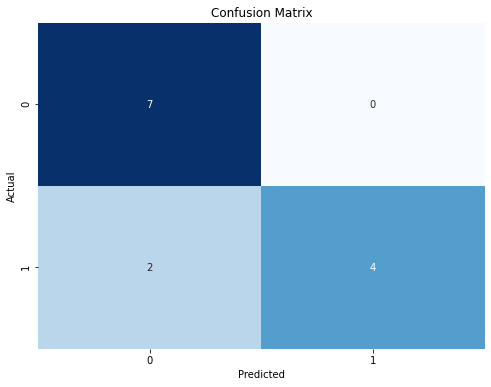

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


##### The confusion matrix provides valuable insights into the following:

True Positive (TP): The number of positive instances that are correctly predicted as positive by the model.

True Negative (TN): The number of negative instances that are correctly predicted as negative by the model.

False Positive (FP): The number of negative instances that are incorrectly predicted as positive by the model.

False Negative (FN): The number of positive instances that are incorrectly predicted as negative by the model.

From the above graph, it is evident that 11 of the instances are classified correctly and 2 of those are classified incorrectly

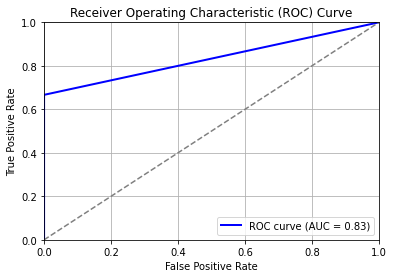

In [60]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Compute Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', linewidth=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


The Receiver Operating Characteristic (ROC) curve is a graphical representation of the performance of a binary classification model. It shows the trade-off between the true positive rate (TPR) and the false positive rate (FPR) at various classification thresholds.
A higher AUC-ROC value indicates better model performance, with values closer to 1 indicating a model with high true positive rate and low false positive rate.In the graph the line should be close to the top left which is the case in our diagram indicating a good perfromance from the model

#### Apart from the confusion matrix and the ROC curve, we can even dig deep into precision recall curve

A precision-recall curve is used to evaluate the trade-off between precision and recall for different probability thresholds in a binary classification model. It plots the precision and recall values for various thresholds, allowing you to analyze the model's performance across different decision boundaries.

to understand the below diagram, lets analyze what does these points and values mean

(0,1): At the beginning of the curve, the threshold is set very low, causing the model to predict almost all samples as positive. As a result, the recall is high (1.0) because the model captures nearly all the true positive samples. However, the precision is low because many of the predicted positives are false positives.

(0.7,1.0): As the threshold increases, the model becomes more conservative and predicts fewer samples as positive. This leads to a decrease in recall as the model fails to capture some of the true positive samples. However, the precision increases because the predicted positives are more likely to be true positives.

(1.0,0.45): Towards the end of the curve, the threshold is set very high, making the model highly selective in predicting positive samples. Consequently, the recall drops significantly as the model misses a large number of true positive samples. At the same time, the precision decreases as the remaining predicted positives are more likely to be false positives.

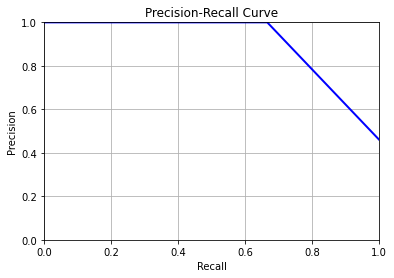

Overall, the shape of the precision-recall curve indicates the trade-off between precision and recall as you change the decision threshold. It is common to observe a decreasing trend in precision as recall decreases.

#### and Calibration Curve

A calibration curve is used to assess the calibration or reliability of a binary classification model. It shows the relationship between predicted probabilities from the model and the actual probabilities of the positive class.In a perfectly calibrated model, the points on the calibration curve would fall along the diagonal line. But in our case, its slightly above the diagonal indicating that the model is overconfident and tends to assign higher probabilities than what is observed in reality

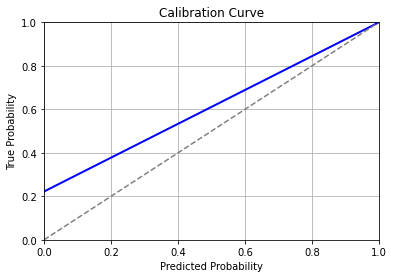

In [ ]:
#Bonus: Identifying the location based on the latitude and longitude using Google  Maps API and
#try to come up with a exact location to maybe verify if the event is happening or not

import requests


# Step 2: Perform Reverse Geocoding
locations = []
API_KEY = "your api key"  #  Google Maps API key

for index, row in df.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    url = f"https://maps.googleapis.com/maps/api/geocode/json?latlng={lat},{lon}&key={API_KEY}"
    response = requests.get(url).json()
    if response['results']:
        location = response['results'][0]['formatted_address']
    else:
        location = "Unknown"
    locations.append(location)

# Step 3: Replace Latitude and Longitude with Locations
df['location'] = locations
df = df.drop(['latitude', 'longitude'], axis=1)


In [ ]:
df.nunique()

In [ ]:
df = df.drop_duplicates()

In [85]:
#locations of the latitudes and longitudes

df['location']

0                  260 Broadway, Brooklyn, NY 10007, USA
1               106 W 1st St, Los Angeles, CA 90012, USA
2                   South Tottenham, London WC2N 5DU, UK
3               130 Queen St, Ottawa, ON K1P 1A5, Canada
4              5911 US-101, San Francisco, CA 94103, USA
                             ...                        
181              Spandauer Str. 8, 10178 Berlin, Germany
182    Proyezd Voskresenskiye Vorota, 1А, Moskva, Rus...
183    Georgia Ave Petworth Station, District of Free...
184                42W5W+8J, Calgary, AB T2P 2V1, Canada
185                260 Broadway, Brooklyn, NY 10007, USA
Name: location, Length: 186, dtype: object

In [ ]:
# Filter the DataFrame and select location and time
filtered_df = df.loc[df['event_occurred'] == 1, ['location', 'timestamp']]

# Print the filtered DataFrame
print(filtered_df)

In [ ]:
filtered_df.nunique()

##### From the above stats, it is evident that there are a total of 10 unique locations, now, let us pinpoint those locations based on the latitude and logitude and identify what exactly is present in those locations

260 Broadway, Brooklyn, NY 10007, USA - BRIDGING ACCESS TO CARE

130 Queen St, Ottawa, ON K1P 1A5, Canada - OFFICE PROPERTY

Spandauer Str. 8, 10178 Berlin, Germany - ITS AN OPEN PARK

Georgia Ave Petworth Station, District of Freedom#8573311~!#, Washington, DC 20036, USA - WASHINGTON DC METRO STATION

106 W 1st St, Los Angeles, CA 90012, USA - LOS ANGELES POLICE DEPARTMENT

5911 US-101, San Francisco, CA 94103, USA - GOLDEN GATE AUDI CLUB

Proyezd Voskresenskiye Vorota, 1А, Moskva, Russia, 109012 -  CONFERENCE CENTER

6 Pl. de l'Hôtel de Ville, 75004 Paris, France - 5 STAR HOTEL DE VILLE

42W5W+8J, Calgary, AB T2P 2V1, Canada - OFFICE PROPERTY

2299 Dallas St, Houston, TX 77003, USA - CITY HALL ANNEX